In [1]:
import tensorflow as tf
from varz.tensorflow import Vars, minimise_l_bfgs_b, minimise_adam
from stheno.tensorflow import GP, EQ, Delta

import numpy as np
import matplotlib.pyplot as plt

from boa.models.fully_factorized_gp_v2 import FullyFactorizedGPModel
from boa.models.gp import GPModel
from boa.models.gpar_v2 import GPARModel
from boa.models.matrix_factorized_gpar_v2 import MatrixFactorizedGPARModel

# Test Independent GP Model vs Reference Implementation

In [3]:
# Target function (noise free).
def f(X):
    return (np.sinc(3 * X) + 0.5 * (X - 0.5)**2).reshape(-1, 1)


# Generate X's and Y's for training.
np.random.seed(42)
X_train = np.array([
    -0.25,
    0,
    0.1,
]).reshape(-1, 1)
Y_train = f(X_train)

In [3]:
# Setup GP model and train.
model = GPModel(kernel='rbf', num_optimizer_restarts=3)
model.set_data(X_train, Y_train)
model.train()

model_v2 = FullyFactorizedGPModel(kernel='rbf', num_optimizer_restarts=3, verbose=False)
model_v2 = model_v2 | (X_train, Y_train)
model_v2.train()

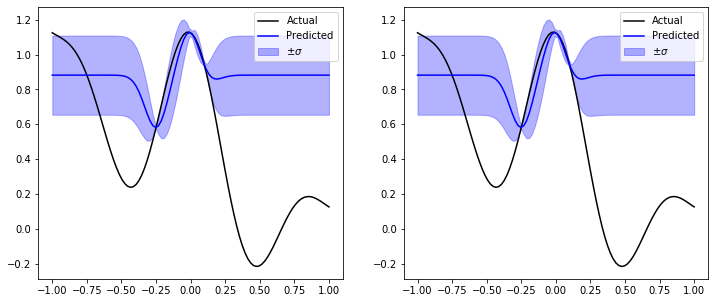

In [4]:
x_candidates = np.linspace(-1, 1, 100).reshape([-1, 1])

pred_mean, pred_var = model.predict_batch(x_candidates)

pred_mean_v2, pred_var_v2 = model_v2.predict_batch(x_candidates)

pred_mean_v2 =  pred_mean_v2.numpy()
pred_var_v2 = pred_var_v2.numpy()

plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(x_candidates, f(x_candidates), color='black', label="Actual")
plt.plot(x_candidates, pred_mean, color='blue', label="Predicted")
plt.fill_between(x_candidates.T[0], (pred_mean + np.sqrt(pred_var)).T[0], (pred_mean - np.sqrt(pred_var)).T[0], color='blue', alpha=0.3, label=r"$\pm\sigma$")

plt.legend()

plt.subplot(122)
plt.plot(x_candidates, f(x_candidates), color='black', label="Actual")
plt.plot(x_candidates, pred_mean_v2, color='blue', label="Predicted")
plt.fill_between(x_candidates.T[0], (pred_mean_v2 + np.sqrt(pred_var_v2)).T[0], (pred_mean_v2 - np.sqrt(pred_var_v2)).T[0], color='blue', alpha=0.3, label=r"$\pm\sigma$")

plt.legend()

plt.show()

In [5]:
m = tf.Variable(tf.ones(1.)) * GP(EQ())

m = m | (X_train, Y_train)

# Test GPAR implementation

In [2]:
# Test function
def f(x):
    return np.sinc(3 * x[:, 0]).reshape(-1, 1)

# Set seed for reproducibility
np.random.seed(42)

# Generate input data
x_train = np.random.rand(8, 2) * 2 - 1
pseudo_point = np.array([[0.8, 0.3]])
x_train = np.vstack([x_train, pseudo_point])

y_train = f(x_train)

# Points for plotting
x_cont = np.arange(-1.5, 1.5, 0.02).reshape(-1, 1)
x_cont = np.hstack([x_cont, x_cont])

In [3]:
# FF-GP model
ff_gp = FullyFactorizedGPModel(kernel='rbf', num_optimizer_restarts=10, verbose=False)
ff_gp = ff_gp | (x_train, y_train)
ff_gp.train()

ff_gp.add_pseudo_point(pseudo_point)
y_pred_ff_gp, var_pred_ff_gp = ff_gp.predict_batch(x_cont)

y_pred_ff_gp = y_pred_ff_gp.numpy()
var_pred_ff_gp = var_pred_ff_gp.numpy()

In [4]:
# GPAR model
gpar = GPARModel(kernel='rbf', num_optimizer_restarts=10, verbose=True)
gpar = gpar | (x_train, y_train)
gpar.train()

gpar.add_pseudo_point(pseudo_point)
y_pred_gpar, var_pred_gpar = gpar.predict_batch(x_cont)

y_pred_gpar = y_pred_gpar.numpy()
var_pred_gpar = var_pred_gpar.numpy()

 /scratch/gf332/BayesOpt/tf2-boa-venv/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning:Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


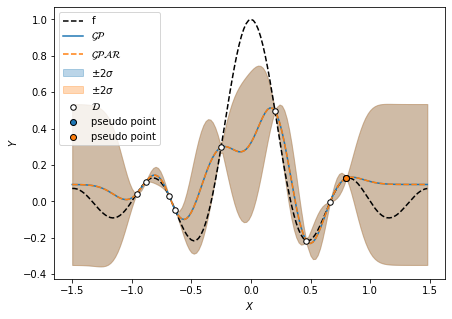

In [6]:
# Plot results
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

ax.plot(x_cont[:, 0], f(x_cont), color='black', linestyle='dashed', label='f', zorder=-1)

ax.plot(x_cont[:, 0], y_pred_ff_gp, color='C0', zorder=-1, label=r'$\mathcal{GP}$')
ax.fill_between(x_cont.T[0],
                (y_pred_ff_gp + 2 * np.sqrt(var_pred_ff_gp)).T[0],
                (y_pred_ff_gp - 2 * np.sqrt(var_pred_ff_gp)).T[0],
                color='C0',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

ax.plot(x_cont[:, 0], y_pred_gpar, color='C1', zorder=-1, label=r'$\mathcal{GPAR}$', linestyle='dashed')
ax.fill_between(x_cont.T[0],
                (y_pred_gpar + 2 * np.sqrt(var_pred_gpar)).T[0],
                (y_pred_gpar - 2 * np.sqrt(var_pred_gpar)).T[0],
                color='C1',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

# Data points
ax.scatter(x=x_train[:, 0], y=y_train[:, 0], s=30, c='white', edgecolors='black', label=r'$\mathcal{D}$')
ax.scatter(x=ff_gp.xs[-1:, 0], y=ff_gp.ys[-1:, 0], c='C0', edgecolors='black', label='pseudo point')
ax.scatter(x=gpar.xs[-1:, 0], y=gpar.ys[-1:, 0], c='C1', edgecolors='black', label='pseudo point')

ax.legend(loc='upper left')
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')

fig.show()